Постройте модель для классификации FashionMNIST. Попробуйте получить качество на тестовой выборке не ниже 88%


In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision as tv
import time

In [2]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

torch.Size([10000, 28, 28])


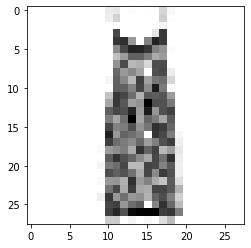

In [3]:
print(test_dataset.data.shape)
plt.imshow(test_dataset.data[300].numpy(), cmap='gray_r')

In [6]:
BATCH_SIZE = 256
LR = 0.002
NUM_EPOCHS = 40
N1 = 256
N2 = 256

train = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, N1),
    # torch.nn.BatchNorm1d(N1),
    torch.nn.Dropout(p=.25),
    torch.nn.ReLU(),
    torch.nn.Linear(N1, N2),
    # torch.nn.Dropout(),
    torch.nn.ReLU(),
    torch.nn.Linear(N2, 10),
)
loss = torch.nn.CrossEntropyLoss()
# trainer = torch.optim.SGD(model.parameters(), LR)
trainer = torch.optim.Adam(model.parameters(), LR)
# trainer = torch.optim.RMSprop(model.parameters(), LR)

start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    train_iter, train_passed = 0, 0
    train_loss, train_acc = 0., 0.
    epoch_time = time.time()

    model.train()
    for F, L in train:
        trainer.zero_grad()
        L_calc = model(F)
        l = loss(L_calc, L)
        l.backward()
        trainer.step()

        train_loss += l.item()
        train_acc += (L_calc.argmax(dim=1) == L).sum().item()
        train_iter += 1
        train_passed += len(F)


    test_iter, test_passed = 0, 0
    test_loss, test_acc = 0., 0.

    model.eval()
    for F, L in test:
        L_calc = model(F)
        l = loss(L_calc, L)

        test_loss += l.item()
        test_acc += (L_calc.argmax(dim=1) == L).sum().item()
        test_iter += 1
        test_passed += len(F)

    print(f'ep: {epoch}, time: {round(time.time() - epoch_time, 1)}, '
          f' TRAIN_LOSS={round(train_loss/train_iter, 4)}'
          f' TRAIN_ACC={round(train_acc/train_passed, 4)}'
          f' TEST_LOSS={round(test_loss/test_iter, 4)}'
          f' TEST_ACC={round(test_acc/test_passed, 4)}')

total_time = round(time.time() - start_time)
print(f'Total time: {total_time // 60} min {total_time % 60} sec')

ep: 1, time: 7.6,  TRAIN_LOSS=0.587 TRAIN_ACC=0.7866 TEST_LOSS=0.4242 TEST_ACC=0.8477
ep: 2, time: 8.4,  TRAIN_LOSS=0.3998 TRAIN_ACC=0.8541 TEST_LOSS=0.3876 TEST_ACC=0.8589
ep: 3, time: 7.9,  TRAIN_LOSS=0.364 TRAIN_ACC=0.8668 TEST_LOSS=0.3911 TEST_ACC=0.8613
ep: 4, time: 8.0,  TRAIN_LOSS=0.3426 TRAIN_ACC=0.8726 TEST_LOSS=0.3655 TEST_ACC=0.8684
ep: 5, time: 8.0,  TRAIN_LOSS=0.3279 TRAIN_ACC=0.8788 TEST_LOSS=0.3692 TEST_ACC=0.8651
ep: 6, time: 7.9,  TRAIN_LOSS=0.3175 TRAIN_ACC=0.8821 TEST_LOSS=0.3619 TEST_ACC=0.8692
ep: 7, time: 7.8,  TRAIN_LOSS=0.3051 TRAIN_ACC=0.8873 TEST_LOSS=0.3495 TEST_ACC=0.8729
ep: 8, time: 7.8,  TRAIN_LOSS=0.2965 TRAIN_ACC=0.8899 TEST_LOSS=0.3435 TEST_ACC=0.8774
ep: 9, time: 8.0,  TRAIN_LOSS=0.2876 TRAIN_ACC=0.8923 TEST_LOSS=0.3506 TEST_ACC=0.8744
ep: 10, time: 8.4,  TRAIN_LOSS=0.2825 TRAIN_ACC=0.8949 TEST_LOSS=0.3317 TEST_ACC=0.8817
ep: 11, time: 8.4,  TRAIN_LOSS=0.2757 TRAIN_ACC=0.8968 TEST_LOSS=0.332 TEST_ACC=0.8772
ep: 12, time: 8.0,  TRAIN_LOSS=0.2723 TRAIN_

Начал с параметров из примеров с цифрами.
Сначала подобрал LR, при 0.002 точность росла довольно быстро и относительно стабильно. При больших значениях на подходе к 88% начинало колбасить, при меньших рост качества сильно замедлялся.
Добавил еще один слой -- результат стал стабильнее. Начинал от 16 нейронов на втором слое, но увеличение количества сказалось положительно на качестве, так что остановился так же на 256.
После 10 эпох качество выходит на 88%, редко переваливало 89% в пределах 20 эпох.

При обучении на тренировочной выборке размер потерь уменьшается, а качество растет, что в принципе логично. А вот на тестовой выборке качество растет, но потери увеличиваются. Пытаюсь понять что это означает..

Вспомнил про регуляризацию, добавил Dropout с вроятностью по умолчанию - 0.5.
Сначала после второго слоя - результат стал еще стабильнее и потери чуть снизились и стабилизировались.
Потом только после первого слоя - скорость обучения упала в два раза, т.е. качество на 88% выходило ближе к 20 эпохе, но при этом все шло очень стабильно и потери продолжали уменьшаться с ростом качества.
Добавление дропаута после обоих слоев ухудшило результат. Оставил только после первого слоя из-за стабильности и уменьшения потерь, хоть и медленнее -- увеличил количество эпох до 40.
Надо еще поиграться с параметром вероятности дропдауна..
Значение вероятности 0.25 увеличило скорость обучения и дало стабильное качество в 89% после 30 эпохи в некоторых случаях.

Попробовал использовать Batch Normalization. Возможно ее нужно правильно настроить, но с параметрами по умолчанию она ухудшила результат.